# Notebook to analyze downloaded gridded climate time-series data 

### Case study:  the Sauk-Suiattle Watershed
<img src="http://www.sauk-suiattle.com/images/Elliott.jpg" 
style="float:right;width:150px;padding:20px">

### Use this Jupyter Notebook to:
    1. HydroShare setup and preparation
    2. Re-establish the paths to the mapping file
    3. Compute daily, monthly, and annual temperature and precipitation statistics
    4. Visualize precipitation results relative to the forcing data
    5. Visualize the time-series trends
    6. Save results back into HydroShare

<br/><br/><br/>
<img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png"
style="float:right;width:150px;padding:20px">

<br/><br/>
#### This data is compiled to digitally observe the watersheds, powered by HydroShare. <br/>Provided by the Watershed Dynamics Group, Dept. of Civil and Environmental Engineering, University of Washington

## 1.  HydroShare Setup and Preparation

To run this notebook, we must import several libaries. These are listed in order of 1) Python standard libraries, 2) hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading and creation, and 3) the observatory_gridded_hydromet library that is downloaded with this notebook. 

In [1]:
# data processing
import os
import pandas as pd, numpy as np, dask, json
import ogh
import seaborn as sns

# data migration library
from utilities import hydroshare

# plotting and shape libraries
%matplotlib inline

# silencing warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
# initialize ogh_meta
meta_file = dict(ogh.ogh_meta())
sorted(meta_file.keys())

['dailymet_bclivneh2013',
 'dailymet_livneh2013',
 'dailymet_livneh2015',
 'dailyvic_livneh2013',
 'dailyvic_livneh2015',
 'dailywrf_bcsalathe2014',
 'dailywrf_salathe2014']

In [3]:
sorted(meta_file['dailymet_livneh2013'].keys())

['decision_steps',
 'delimiter',
 'domain',
 'end_date',
 'file_format',
 'filename_structure',
 'reference',
 'spatial_resolution',
 'start_date',
 'subdomain',
 'temporal_resolution',
 'variable_info',
 'variable_list',
 'web_protocol']

Establish a secure connection with HydroShare by instantiating the hydroshare class that is defined within hs_utils. In addition to connecting with HydroShare, this command also sets and prints environment variables for several parameters that will be useful for saving work back to HydroShare. 

In [5]:
notebookdir = os.getcwd()

hs=hydroshare.hydroshare()
homedir = hs.getContentPath(os.environ["HS_RES_ID"])
os.chdir(homedir)
print('Data will be loaded from and save to:'+homedir)

Adding the following system variables:
   HS_USR_NAME = jphuong
   HS_RES_ID = 875277a7854f46ba97ff655f571ea357
   HS_RES_TYPE = compositeresource
   JUPYTER_HUB_IP = jupyter.cuahsi.org

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => jphuong

The hs_utils library requires a secure connection to your HydroShare account.
Enter the HydroShare password for user 'jphuong': ········
Successfully established a connection with HydroShare
Data will be loaded from and save to:/home/jovyan/work/notebooks/data/875277a7854f46ba97ff655f571ea357/875277a7854f46ba97ff655f571ea357/data/contents


If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon to return to the File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

## 2. Get list of gridded climate points for the watershed

For visualization purposes, we will also remap the study site shapefile, which is stored in HydroShare at the following url: https://www.hydroshare.org/resource/c532e0578e974201a0bc40a37ef2d284/. Since the shapefile was previously migrated, we can select 'N' for no overwriting.

In the usecase1 notebook, the treatgeoself function identified the gridded cell centroid coordinates that overlap with our study site. These coordinates were documented within the mapping file, which will be remapped here. In the usecase2 notebook, the downloaded files were cataloged within the mapping file, so we will use the mappingfileSummary function to characterize the files available for Sauk-Suiattle for each gridded data product.

In [6]:
"""
1/16-degree Gridded cell centroids
"""
# List of available data
hs.getResourceFromHydroShare('ef2d82bf960144b4bfb1bae6242bcc7f')
NAmer = hs.content['NAmer_dem_list.shp']


"""
Sauk
"""
# Watershed extent
hs.getResourceFromHydroShare('c532e0578e974201a0bc40a37ef2d284')
sauk = hs.content['wbdhub12_17110006_WGS84_Basin.shp']

# reproject the shapefile into WGS84
ogh.reprojShapefile(sourcepath=sauk)

This resource already exists in your userspace.
ef2d82bf960144b4bfb1bae6242bcc7f/
|-- ef2d82bf960144b4bfb1bae6242bcc7f/
|   |-- bagit.txt
|   |-- manifest-md5.txt
|   |-- readme.txt
|   |-- tagmanifest-md5.txt
|   |-- data/
|   |   |-- resourcemap.xml
|   |   |-- resourcemetadata.xml
|   |   |-- contents/
|   |   |   |-- NAmer_dem_list.cpg
|   |   |   |-- NAmer_dem_list.dbf
|   |   |   |-- NAmer_dem_list.prj
|   |   |   |-- NAmer_dem_list.sbn
|   |   |   |-- NAmer_dem_list.sbx
|   |   |   |-- NAmer_dem_list.shp
|   |   |   |-- NAmer_dem_list.shx

Do you want to overwrite these data [Y/n]? y
Download Finished                               
Successfully downloaded resource ef2d82bf960144b4bfb1bae6242bcc7f


This resource already exists in your userspace.
c532e0578e974201a0bc40a37ef2d284/
|-- c532e0578e974201a0bc40a37ef2d284/
|   |-- bagit.txt
|   |-- manifest-md5.txt
|   |-- readme.txt
|   |-- tagmanifest-md5.txt
|   |-- data/
|   |   |-- resourcemap.xml
|   |   |-- resourcemetadata.xml
|   |   |-- contents/
|   |   |   |-- wbdhub12_17110006_WGS84_Basin.cpg
|   |   |   |-- wbdhub12_17110006_WGS84_Basin.shp
|   |   |   |-- wbdhub12_17110006_WGS84_Basin.shx
|   |   |   |-- wbdhub12_17110006_WGS84_Basin.dbf
|   |   |   |-- wbdhub12_17110006_WGS84_Basin.prj

Do you want to overwrite these data [Y/n]? y
Download Finished                               
Successfully downloaded resource c532e0578e974201a0bc40a37ef2d284


### Summarize the file availability from each watershed mapping file

In [7]:
# map the mappingfiles from usecase1
mappingfile1=ogh.treatgeoself(shapefile=sauk, NAmer=NAmer, buffer_distance=0.06,
                              mappingfile=os.path.join(homedir,'Sauk_mappingfile.csv'))
print(mappingfile1)

t1 = ogh.mappingfileSummary(listofmappingfiles = [mappingfile1], 
                            listofwatershednames = ['Sauk-Suiattle river'],
                            meta_file=meta_file)

t1

(99, 4)
   FID       LAT      LONG_    ELEV
0    0  48.53125 -121.59375  1113.0
1    1  48.46875 -121.46875   646.0
2    2  48.46875 -121.53125   321.0
3    3  48.46875 -121.59375   164.0
4    4  48.46875 -121.65625   369.0
/home/jovyan/work/notebooks/data/875277a7854f46ba97ff655f571ea357/875277a7854f46ba97ff655f571ea357/data/contents/Sauk_mappingfile.csv


Watershed,Sauk-Suiattle river
Median elevation in meters [range](Number of gridded cells),1171[164-2216] (n=99)


## 3.  Compare Hydrometeorology 

This section performs computations and generates plots of the Livneh 2013 and Salathe 2014 mean temperature and mean total monthly precipitation in order to compare them with each other. The generated plots are automatically downloaded and saved as .png files within the "homedir" directory.

Let's compare the Livneh 2013 and Salathe 2014 using the period of overlapping history.

In [8]:
%%time

ogh.getDailyMET_livneh2013(homedir, mappingfile1)
ogh.getDailyWRF_salathe2014(homedir, mappingfile1)

Meteorology_Livneh_CONUSExt_v.1.2_2013_48.53125_-121.59375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.40625_-121.40625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.40625_-121.09375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-120.96875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.28125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.46875_-121.46875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.40625_-121.46875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.40625_-121.15625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.03125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.34375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.46875_-121.53125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.40625_-121.53125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.40625_-121.21875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.09375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_

downloaded: data_48.21875_-120.96875
downloaded: data_48.21875_-121.34375
downloaded: data_48.21875_-121.21875
downloaded: data_48.21875_-121.09375
downloaded: data_48.21875_-121.46875
downloaded: data_48.21875_-121.59375
downloaded: data_48.15625_-120.90625
downloaded: data_48.15625_-121.03125
downloaded: data_48.15625_-121.15625
downloaded: data_48.15625_-121.28125
downloaded: data_48.15625_-121.40625
downloaded: data_48.15625_-121.53125
downloaded: data_48.15625_-121.65625
downloaded: data_48.09375_-120.90625
downloaded: data_48.09375_-121.28125
downloaded: data_48.09375_-121.03125
downloaded: data_48.09375_-121.40625
downloaded: data_48.09375_-121.53125
downloaded: data_48.09375_-121.65625
downloaded: data_48.21875_-121.03125
downloaded: data_48.09375_-121.15625
downloaded: data_48.21875_-121.28125
downloaded: data_48.21875_-121.40625
downloaded: data_48.21875_-121.15625
downloaded: data_48.21875_-121.53125
downloaded: data_48.15625_-120.96875
downloaded: data_48.21875_-121.65625
d

In [9]:
t1 = ogh.mappingfileSummary(listofmappingfiles = [mappingfile1], 
                            listofwatershednames = ['Sauk-Suiattle river'],
                            meta_file=meta_file)

t1

Watershed,Sauk-Suiattle river
Median elevation in meters [range](Number of gridded cells),1171[164-2216] (n=99)
dailymet_livneh2013,1171[164-2216] (n=99)
dailywrf_salathe2014,1171[164-2216] (n=99)


### Create a dictionary of climate variables for the long-term mean (ltm).
#### INPUT: gridded meteorology ASCII files located from the Sauk-Suiattle Mapping file. The inputs to gridclim_dict() include the folder location and name of the hydrometeorology data, the file start and end, the analysis start and end, and the elevation band to be included in the analsyis (max and min elevation). <br/>OUTPUT: dictionary of dataframes where rows are temporal summaries and columns are spatial summaries

In [10]:
# Livneh et al., 2013
dr1 = meta_file['dailymet_livneh2013']

# Salathe et al., 2014
dr2 = meta_file['dailywrf_salathe2014']

# define overlapping time window
dr = ogh.overlappingDates(date_set1=tuple([dr1['start_date'], dr1['end_date']]), 
                          date_set2=tuple([dr2['start_date'], dr2['end_date']]))
dr

('1950-01-01', '2010-12-31')

In [11]:
%%time
ltm = ogh.gridclim_dict(mappingfile=mappingfile1,
                        metadata=meta_file,
                        variable_list=['PRECIP'],
                        dataset='dailymet_livneh2013',
                        subset_start_date=dr[0],
                        subset_end_date=dr[1])

Number of data files within elevation range (164.0-2216.0 m): 99
PRECIP dataframe reading complete:0:00:01.570361
PRECIP_dailymet_livneh2013 calculations completed in 0:00:00.084997
CPU times: user 3.74 s, sys: 1.02 s, total: 4.76 s
Wall time: 1.66 s


### Compute the total monthly and yearly precipitation, as well as the mean values across time and across stations
#### INPUT: daily precipitation for each station from the long-term mean dictionary (ltm) <br/>OUTPUT: Append the computed dataframes and values into the ltm dictionary

In [12]:
# compute sums and mean monthly an yearly sums
ltm = ogh.aggregate_space_time_sum(df_dict=ltm,
                                   suffix='PRECIP_dailymet_livneh2013',
                                   start_date=dr[0],
                                   end_date=dr[1])

PRECIP_dailymet_livneh2013 calculations completed in 0:00:00.245419


## Repeat spatial-temporal computations with Salathe et al 2014 WRF data

In [13]:
%%time
ltm = ogh.gridclim_dict(mappingfile=mappingfile1,
                        metadata=meta_file,
                        variable_list=['PRECIP'],
                        dataset='dailywrf_salathe2014',
                        subset_start_date=dr[0],
                        subset_end_date=dr[1],
                        df_dict=ltm)

# compute sums and mean monthly an yearly sums
ltm = ogh.aggregate_space_time_sum(df_dict=ltm,
                                   suffix='PRECIP_dailywrf_salathe2014',
                                   start_date=dr[0],
                                   end_date=dr[1])

Number of data files within elevation range (164.0-2216.0 m): 99
PRECIP dataframe reading complete:0:00:01.654200
PRECIP_dailywrf_salathe2014 calculations completed in 0:00:00.062633
PRECIP_dailywrf_salathe2014 calculations completed in 0:00:00.232549
CPU times: user 2.78 s, sys: 624 ms, total: 3.41 s
Wall time: 1.96 s


In [14]:
# print the name of the Livneh et al. 2013 raw MET and Salathe et al. 2014 raw WRF dataframes and values within ltm
sorted(ltm.keys())

['PRECIP_dailymet_livneh2013',
 'PRECIP_dailywrf_salathe2014',
 'anomyear_PRECIP_dailymet_livneh2013',
 'anomyear_PRECIP_dailywrf_salathe2014',
 'meanalldailysum_PRECIP_dailymet_livneh2013',
 'meanalldailysum_PRECIP_dailywrf_salathe2014',
 'meanallmonthsum_PRECIP_dailymet_livneh2013',
 'meanallmonthsum_PRECIP_dailywrf_salathe2014',
 'meanallyear_PRECIP_dailymet_livneh2013',
 'meanallyear_PRECIP_dailywrf_salathe2014',
 'meanallyearsum_PRECIP_dailymet_livneh2013',
 'meanallyearsum_PRECIP_dailywrf_salathe2014',
 'meanbydaily_PRECIP_dailymet_livneh2013',
 'meanbydaily_PRECIP_dailywrf_salathe2014',
 'meanbymonth_PRECIP_dailymet_livneh2013',
 'meanbymonth_PRECIP_dailywrf_salathe2014',
 'meanbymonthsum_PRECIP_dailymet_livneh2013',
 'meanbymonthsum_PRECIP_dailywrf_salathe2014',
 'meanbyyear_PRECIP_dailymet_livneh2013',
 'meanbyyear_PRECIP_dailywrf_salathe2014',
 'meanbyyearsum_PRECIP_dailymet_livneh2013',
 'meanbyyearsum_PRECIP_dailywrf_salathe2014',
 'meandaily_PRECIP_dailymet_livneh2013',
 '

In [15]:
# initialize list of outputs
files=[]

# create the destination path for the dictionary of dataframes
ltm_sauk=os.path.join(homedir, 'ltm_sauk.json')
ogh.saveDictOfDf(dictionaryObject=ltm, outfilepath=ltm_sauk)
files.append(ltm_sauk)

# append the mapping file for Sauk-Suiattle gridded cell centroids
files.append(mappingfile1)

### Visualize the "average monthly total precipitations"

#### INPUT: dataframe with each month as a row and each station as a column. <br/>OUTPUT: A png file that represents the distribution across stations (in Wateryear order)

In [16]:
# # two lowest elevation locations
lowE_ref = ogh.findCentroidCode(mappingfile=mappingfile1, colvar='ELEV', colvalue=164)

# one highest elevation location
highE_ref = ogh.findCentroidCode(mappingfile=mappingfile1, colvar='ELEV', colvalue=2216)

# combine references together
reference_lines = highE_ref + lowE_ref
reference_lines


[(69, 48.09375, -121.09375),
 (3, 48.46875, -121.59375),
 (24, 48.34375, -121.53125)]

In [17]:
# consider value range when comparing Livneh to Salathe 
vr = ogh.valueRange([ltm['meanbymonthsum_PRECIP_dailymet_livneh2013'], 
                     ltm['meanbymonthsum_PRECIP_dailywrf_salathe2014']])

print(vr.min(), vr.max())

35.0352458852 579.924590705


In [18]:
temp, nstation = ogh.mappingfileToDF(mappingfile1)
temp.head(10)

Number of gridded data files:99
Minimum elevation: 164.0m
Mean elevation: 1151.040404040404m
Maximum elevation: 2216.0m


,FID,LAT,LONG_,ELEV,dailymet_livneh2013,dailywrf_salathe2014
0,0,48.53125,-121.59375,1113.0,/home/jovyan/work/notebooks/data/875277a7854f4...,/home/jovyan/work/notebooks/data/875277a7854f4...
1,1,48.46875,-121.46875,646.0,/home/jovyan/work/notebooks/data/875277a7854f4...,/home/jovyan/work/notebooks/data/875277a7854f4...
2,2,48.46875,-121.53125,321.0,/home/jovyan/work/notebooks/data/875277a7854f4...,/home/jovyan/work/notebooks/data/875277a7854f4...
3,3,48.46875,-121.59375,164.0,/home/jovyan/work/notebooks/data/875277a7854f4...,/home/jovyan/work/notebooks/data/875277a7854f4...
4,4,48.46875,-121.65625,369.0,/home/jovyan/work/notebooks/data/875277a7854f4...,/home/jovyan/work/notebooks/data/875277a7854f4...
5,5,48.40625,-121.09375,1535.0,/home/jovyan/work/notebooks/data/875277a7854f4...,/home/jovyan/work/notebooks/data/875277a7854f4...
6,6,48.40625,-121.15625,1518.0,/home/jovyan/work/notebooks/data/875277a7854f4...,/home/jovyan/work/notebooks/data/875277a7854f4...
7,7,48.40625,-121.21875,1218.0,/home/jovyan/work/notebooks/data/875277a7854f4...,/home/jovyan/work/notebooks/data/875277a7854f4...
8,8,48.40625,-121.28125,1661.0,/home/jovyan/work/notebooks/data/875277a7854f4...,/home/jovyan/work/notebooks/data/875277a7854f4...
9,9,48.40625,-121.34375,1324.0,/home/jovyan/work/notebooks/data/875277a7854f4...,/home/jovyan/work/notebooks/data/875277a7854f4...


In [ ]:
# """
# #Higher resolution children gridded cells 
# #get data from Lower resolution parent grid cells to the children
# """
# import landlab as L2

# watershed_dem_sc = os.path.join(homedir, 'DEM_10m.asc')
# (rmg_sc, z_sc) = L2.io.read_esri_ascii(watershed_dem_sc, name='topographic__elevation')
# rmg_sc.set_watershed_boundary_condition(z_sc)

In [ ]:
# test0=pd.read_table(watershed_dem_sc, nrows=5, sep='\s+', header=None).set_index(0)[1].to_dict()
# print(test0)

# test1 = pd.read_table(watershed_dem_sc, 
#                       skiprows=6, 
#                       nrows=test0['nrows'],
#                       sep='\s+',
#                       header=None)
# print(test1.tail())

In [ ]:
# test1.unstack().as_matrix().shape

In [ ]:
# test1.as_matrix().shape

In [19]:
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
mpl.style.use('tableau-colorblind10')

import shapely.ops
from shapely.geometry import MultiPolygon, shape, point, box, Polygon
from mpl_toolkits.basemap import Basemap
import geopandas as gpd

In [ ]:
# read in the mappingfile
map_df, nstation = ogh.mappingfileToDF(mappingfile1)
map_df.head(10)

# loop though each LAT/LONG_ +/-0.06250 centroid into gridded cells
geom=[]
midpt = 0.06250
for ind in map_df.index:
    mid = map_df.loc[ind]
    geom.append(box(mid.LONG_- midpt, mid.LAT - midpt, mid.LONG_ + midpt, mid.LAT + midpt, ccw=True))

test = gpd.GeoDataFrame(map_df, crs={'init':'epsg:4326'}, geometry=geom)

# compile gridded cells to extract bounding box
test['shapeName'] = 1

# dissolve shape into new shapefile
newShape = test.dissolve(by='shapeName').reset_index()
newShape.bounds

# take the minx and miny, and centroid_x and centroid_y
minx, miny, maxx, maxy = newShape.bounds.loc[0]
lon0, lat0 = np.array(newShape.centroid[0])

# generate the basemap raster
fig = plt.figure(figsize=(10,10), dpi=500)
ax1 = plt.subplot2grid((1,1),(0,0))
m = Basemap(projection='tmerc', resolution='h', ax=ax1, lat_0=lat0, lon_0=lon0,
            llcrnrlon=minx, llcrnrlat=miny, urcrnrlon=maxx, urcrnrlat=maxy)

# transform each polygon to the utm basemap projection
for ind in newShape.index:
    eachpol = newShape.loc[ind]
    newShape.loc[ind,'g2'] = shapely.ops.transform(m, eachpol['geometry'])

    
minx, miny, maxx, maxy = newShape['g2'].bounds.loc[0]


Number of gridded data files:99
Minimum elevation: 164.0m
Mean elevation: 1151.040404040404m
Maximum elevation: 2216.0m
-121.78125 47.84375 -120.84375 48.59375
122.60987004411436 -99.61975587982306 70041.535561452 83348.40050629438


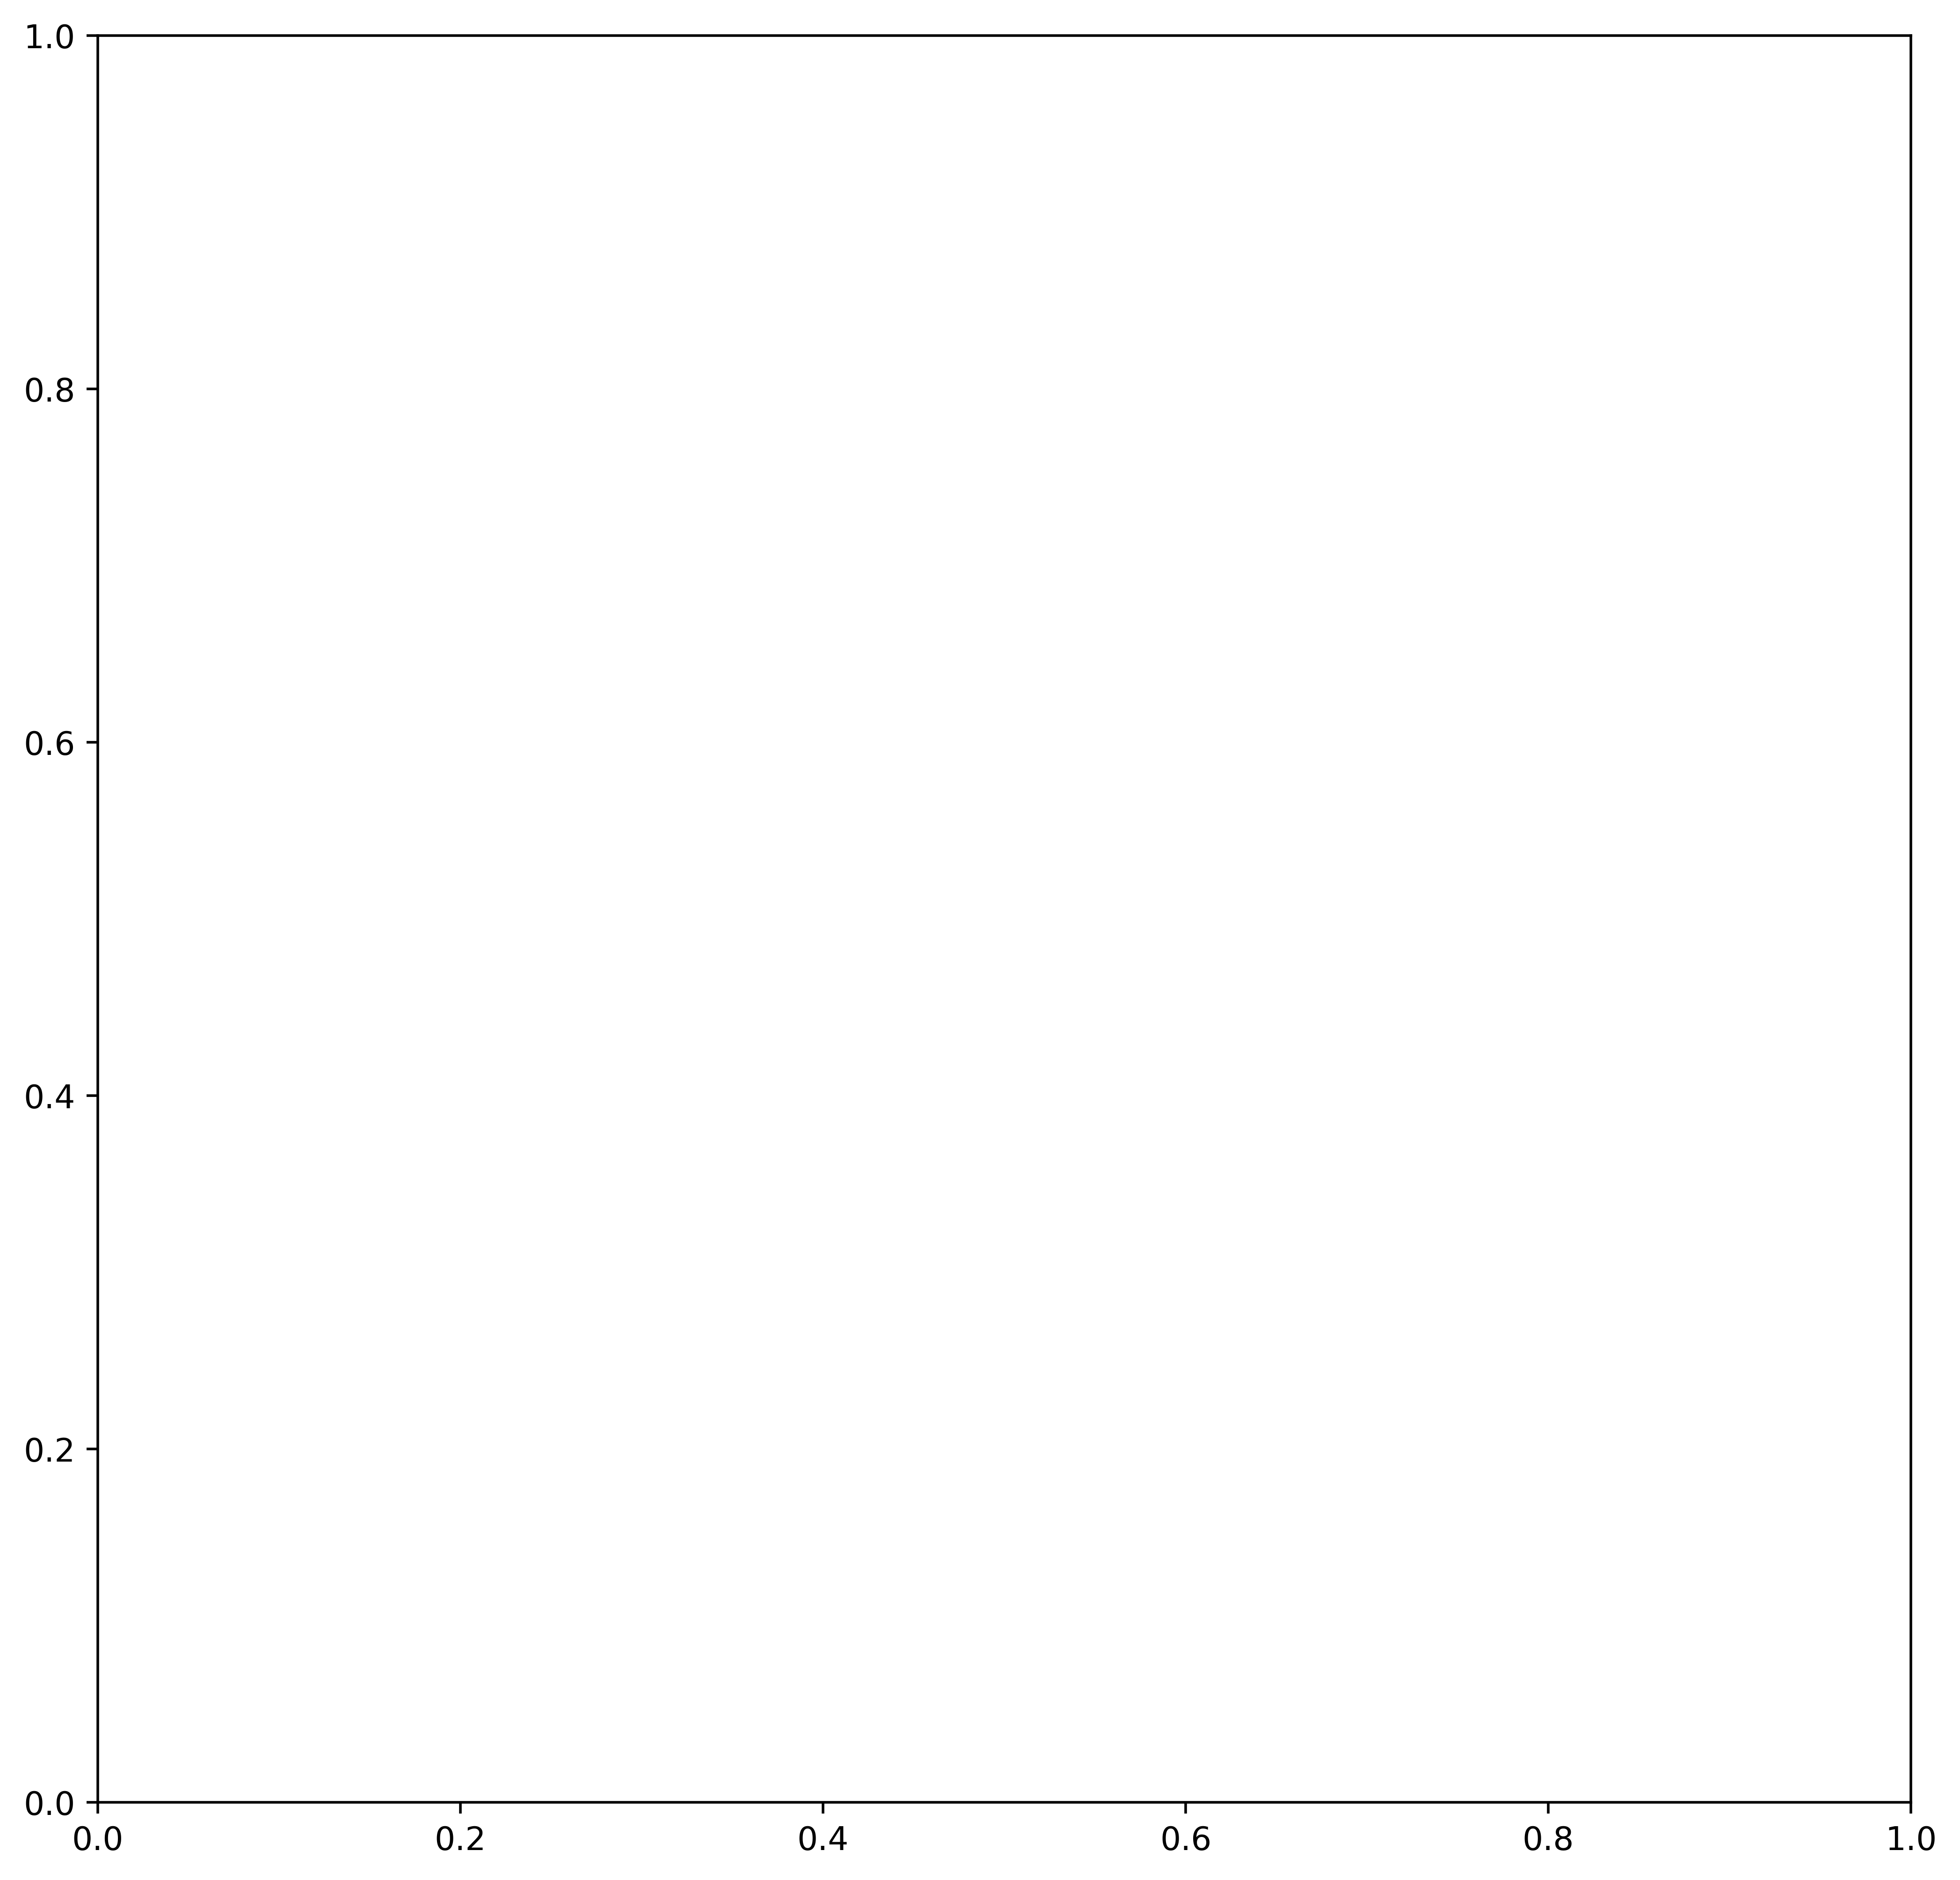

In [20]:
# def mappingfileToUTM (mappingfile, spatial_resolution, starting_shape_projection={'init':'epsg:4326'}):

# read in the mappingfile
#map_df, nstation = ogh.mappingfileToDF(mappingfile)
map_df, nstation = ogh.mappingfileToDF(mappingfile1)

# turn mapping file coordinates into LatLong gridded cells
#midpt = spatial_resolution
midpt = 0.06250
geom=[]
for ind in map_df.index:
    mid = map_df.loc[ind]
    geom.append(box(mid.LONG_- midpt, mid.LAT - midpt, mid.LONG_ + midpt, mid.LAT + midpt, ccw=True))

# assemble geodataframe for each cell
test = gpd.GeoDataFrame(map_df, crs={'init':'epsg:4326'}, geometry=geom)

# dissolve into a single shape polygon
test['shapeName'] = 1
newShape = test.dissolve(by='shapeName').reset_index()
del test['shapeName']

# take the bounding box and centroids coordinates
minx, miny, maxx, maxy = newShape.bounds.iloc[0]
lon0, lat0 = np.array(newShape.centroid[0])
print(minx, miny, maxx, maxy)

# generate the basemap raster
fig = plt.figure(figsize=(10,10), dpi=500)
ax1 = plt.subplot2grid((1,1),(0,0))
m = Basemap(projection='tmerc', resolution='h', ax=ax1, lat_0=lat0, lon_0=lon0,
            llcrnrlon=minx, llcrnrlat=miny, urcrnrlon=maxx, urcrnrlat=maxy)
    
# transform each polygon to the utm basemap projection
for ind in newShape.index:
    eachpol = newShape.loc[ind]
    newShape.loc[ind,'geometry'] = shapely.ops.transform(m, eachpol['geometry'])

# print the bounds by the new UTM projection
minx, miny, maxx, maxy = newShape.bounds.iloc[0]
print(minx, miny, maxx, maxy)

# transform each polygon to the utm basemap projection
for ind in test.index:
    eachpol = test.loc[ind]
    test.loc[ind,'geometry'] = shapely.ops.transform(m, eachpol['geometry'])

In [21]:
tmp = gpd.GeoDataFrame(test, crs={'init':m.projection}, geometry=test['geometry'])
tmp

,FID,LAT,LONG_,ELEV,dailymet_livneh2013,dailywrf_salathe2014,geometry
0,0,48.53125,-121.59375,1113.0,/home/jovyan/work/notebooks/data/875277a7854f4...,/home/jovyan/work/notebooks/data/875277a7854f4...,"POLYGON ((18896.78628408417 69416.17836150393,..."
1,1,48.46875,-121.46875,646.0,/home/jovyan/work/notebooks/data/875277a7854f4...,/home/jovyan/work/notebooks/data/875277a7854f4...,"POLYGON ((28132.97755791347 62449.17954685914,..."
2,2,48.46875,-121.53125,321.0,/home/jovyan/work/notebooks/data/875277a7854f4...,/home/jovyan/work/notebooks/data/875277a7854f4...,"POLYGON ((23505.62958869326 62455.83073076481,..."
3,3,48.46875,-121.59375,164.0,/home/jovyan/work/notebooks/data/875277a7854f4...,/home/jovyan/work/notebooks/data/875277a7854f4...,"POLYGON ((18878.28308055772 62466.25692643068,..."
4,4,48.46875,-121.65625,369.0,/home/jovyan/work/notebooks/data/875277a7854f4...,/home/jovyan/work/notebooks/data/875277a7854f4...,"POLYGON ((14250.93867952552 62480.45815440059,..."
5,5,48.40625,-121.09375,1535.0,/home/jovyan/work/notebooks/data/875277a7854f4...,/home/jovyan/work/notebooks/data/875277a7854f4...,"POLYGON ((55923.91059851096 55538.70749556006,..."
6,6,48.40625,-121.15625,1518.0,/home/jovyan/work/notebooks/data/875277a7854f4...,/home/jovyan/work/notebooks/data/875277a7854f4...,"POLYGON ((51290.90038355587 55522.704549935, 5..."
7,7,48.40625,-121.21875,1218.0,/home/jovyan/work/notebooks/data/875277a7854f4...,/home/jovyan/work/notebooks/data/875277a7854f4...,"POLYGON ((46657.88779566876 55510.47761038221,..."
8,8,48.40625,-121.28125,1661.0,/home/jovyan/work/notebooks/data/875277a7854f4...,/home/jovyan/work/notebooks/data/875277a7854f4...,"POLYGON ((42024.87346970989 55502.02665271432,..."
9,9,48.40625,-121.34375,1324.0,/home/jovyan/work/notebooks/data/875277a7854f4...,/home/jovyan/work/notebooks/data/875277a7854f4...,"POLYGON ((37391.85804048228 55497.35166021354,..."


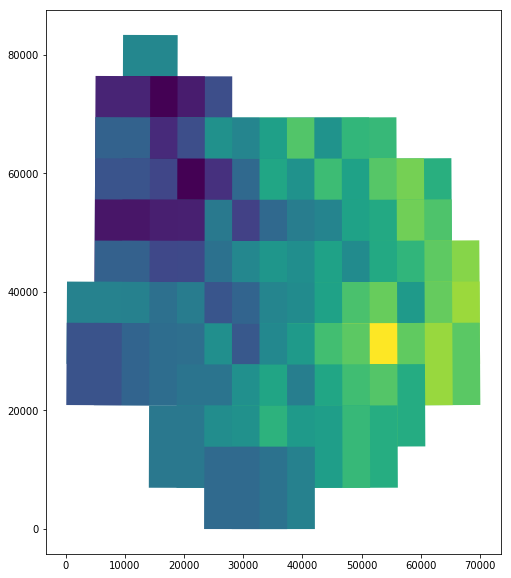

In [22]:
test3 = tmp.plot(column='ELEV', figsize=(10,10))

In [26]:
maxx, minx, maxx-minx

(70041.535561452, 122.60987004411436, 69918.92569140787)

In [27]:
(maxx-minx)/100

699.1892569140787

In [23]:
import landlab.grid.raster as r

def rasterDimensions (maxx, maxy, minx=0, miny=0, dy=100, dx=100):
    # construct the range
    x = pd.Series(range(int(minx),int(maxx)+1,1))
    y = pd.Series(range(int(miny),int(maxy)+1,1))
    
    # filter for values that meet the increment or is the last value
    cols = pd.Series(x.index).apply(lambda x1: x[x1] if x1 % dx == 0 or x1==x[0] or x1==x.index[-1] else None)
    rows = pd.Series(y.index).apply(lambda y1: y[y1] if y1 % dy == 0 or y1==y[0] or y1==y.index[-1] else None)
    
    # construct the indices
    row_list = np.array(rows.loc[pd.notnull(rows)])
    col_list = np.array(cols.loc[pd.notnull(cols)])
    
    # construct the raster
    raster = r.RasterModelGrid(len(row_list), len(col_list), dx=dx)
    raster.add_zeros
    return(raster, row_list, col_list)

In [24]:
raster, t1, t2 = rasterDimensions (minx=minx, miny=miny, maxx=maxx, maxy=maxy)

KeyboardInterrupt: 

In [ ]:
raster.shape

In [ ]:
t1, t2

In [ ]:
raster.boundary_nodes

In [28]:
def mappingfileToRaster(mappingfile, spatial_resolution=0.01250, approx_distance_m_x=6000):
    # assess raster dimensions from mappingfile
    mf, nstations = mappingfileToDF(mappingfile, colvar=None)
    ncol = int((mf.LONG_.max()-mf.LONG_.min())/spatial_resolution +1)
    nrow = int((mf.LAT.max()-mf.LAT.min())/spatial_resolution +1)
    
    # dimensions of the raster
    row_list = [mf.LAT.min() + spatial_resolution*(station) for station in range(0,nrow,1)]    
    col_list = [mf.LONG_.min() + spatial_resolution*(station) for station in range(0,ncol,1)]
    
    # initialize RasterModelGrid
    raster = r.RasterModelGrid(nrow, ncol, dx=approx_distance_m_x)
    raster.add_zeros

    # initialize node list
    df_list=[]

    # loop through the raster nodes (bottom to top arrays)
    for row_index, nodelist in enumerate(raster.nodes):
        
        # index bottom to top arrays with ordered Latitude
        lat = row_list[row_index]
        
        # index left to right with ordered Longitude
        for nodeid, long_ in zip(nodelist, col_list):
            df_list.append([nodeid, lat, long_])

    # convert to dataframe
    df = pd.DataFrame.from_records(df_list).rename(columns={0:'nodeid',1:'LAT',2:'LONG_'})
    
    # identify raster nodeid and equivalent mappingfile FID
    df = df.merge(mf[['FID','LAT','LONG_','ELEV']], how='outer', on=['LAT','LONG_'])
    return(df, raster)

In [29]:
nodeXmap, raster = ogh.mappingfileToRaster(mappingfile=mappingfile1,
                                           spatial_resolution=0.06250,
                                           approx_distance_m_x=6000)

Number of gridded data files:99
Minimum elevation: 164.0m
Mean elevation: 1151.040404040404m
Maximum elevation: 2216.0m


In [30]:
raster.shape

(11, 14)

In [31]:
vector = ogh.rasterVector(vardf=ltm['meanbymonthsum_PRECIP_dailymet_livneh2013'],
                          vardf_dateindex=3,
                          crossmap=nodeXmap,
                          nodata=-9999)
np.array(vector)

array([-9999.        , -9999.        , -9999.        , -9999.        ,
       -9999.        ,   234.65245907,   256.33729474,   224.45204941,
       -9999.        , -9999.        , -9999.        , -9999.        ,
       -9999.        , -9999.        , -9999.        , -9999.        ,
       -9999.        ,   267.02008248,   232.85737679,   233.93483633,
         256.28565534,   230.6356558 ,   234.46106549,   243.01475403,
         221.10655769, -9999.        , -9999.        , -9999.        ,
       -9999.        , -9999.        , -9999.        , -9999.        ,
         226.75614739,   232.69344269,   235.81639367,   223.58196674,
         246.46926234,   258.71270454,   246.05286828,   252.83032777,
       -9999.        , -9999.        ,   238.55532793,   266.92213144,
         258.44999998,   251.17582049,   233.96967234,   220.93688538,
         212.45860631,   205.83073754,   268.62622979,   262.35532761,
         267.79958967,   262.18688497,   240.16434467,   289.25163966,
      

In [32]:
vector = ogh.rasterVector(vardf=ltm['meanbymonthsum_PRECIP_dailywrf_salathe2014'],
                          vardf_dateindex=3,
                          crossmap=nodeXmap,
                          nodata=-9999)
vector

0     -9999.000000
1     -9999.000000
2     -9999.000000
3     -9999.000000
4     -9999.000000
5       326.094098
6       334.488033
7       330.020492
8     -9999.000000
9     -9999.000000
10    -9999.000000
11    -9999.000000
12    -9999.000000
13    -9999.000000
14    -9999.000000
15    -9999.000000
16    -9999.000000
17      336.984590
18      345.145902
19      349.569672
20      355.710984
21      351.704918
22      344.478197
23      333.419016
24      306.889016
25    -9999.000000
26    -9999.000000
27    -9999.000000
28    -9999.000000
29    -9999.000000
          ...     
124   -9999.000000
125   -9999.000000
126   -9999.000000
127     224.923934
128     234.996066
129     243.951311
130     246.859180
131   -9999.000000
132   -9999.000000
133   -9999.000000
134   -9999.000000
135   -9999.000000
136   -9999.000000
137   -9999.000000
138   -9999.000000
139   -9999.000000
140   -9999.000000
141   -9999.000000
142     266.109016
143   -9999.000000
144   -9999.000000
145   -9999.

### Visualize the "average monthly total precipitation"

## 5. Save the results back into HydroShare
<a name="creation"></a>

Using the `hs_utils` library, the results of the Geoprocessing steps above can be saved back into HydroShare.  First, define all of the required metadata for resource creation, i.e. *title*, *abstract*, *keywords*, *content files*.  In addition, we must define the type of resource that will be created, in this case *genericresource*.  

***Note:*** Make sure you save the notebook at this point, so that all notebook changes will be saved into the new HydroShare resource.

### Total files and image to migrate

In [ ]:
len(files)

In [ ]:
# for each file downloaded onto the server folder, move to a new HydroShare Generic Resource
title = 'Computed spatial-temporal summaries of two gridded data product data sets for Sauk-Suiattle'
abstract = 'This resource contains the computed summaries for the Meteorology data from Livneh et al. 2013 and the WRF data from Salathe et al. 2014.'
keywords = ['Sauk-Suiattle', 'Livneh 2013', 'Salathe 2014','climate','hydromet','watershed', 'visualizations and summaries'] 
rtype = 'genericresource'

# create the new resource
resource_id = hs.createHydroShareResource(abstract, 
                                          title,
                                          keywords=keywords, 
                                          resource_type=rtype, 
                                          content_files=files, 
                                          public=False)